# HGCAL FE studies

### imports and initial setup

In [1]:
#imports and setup

%matplotlib inline
%cd /home/naodell/work/hgcal

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from descartes import PolygonPatch
from tqdm import tqdm_notebook

from skhep.modeling import bayesian_blocks
import scripts.helpers as hlp
import scripts.readout_algorithms as algos

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

/home/naodell/work/hgcal


### get the data mixtures

In the script `**.py`, I make mixtures of signal and pileup samples.  

In [31]:
gen_list = []
df_list = []
threshold_list = []
inputdir = 'data/mc_mixtures/single_electron_pt35_skim_test'
for filename in os.listdir(inputdir):
    data_file = open(f'{inputdir}/{filename}', 'rb')
    threshold = pickle.load(data_file)
    gen = pickle.load(data_file)
    df = pickle.load(data_file)
    
    threshold_list.extend(len(df)*[threshold, ])
    gen_list.extend(gen)
    df_list.extend(df)
    data_file.close()

algo_list = ['baseline', 
             'threshold_1bx_esort',  'threshold_1bx_nosort', 
             'threshold_8bx_esort',  'threshold_8bx_nosort'
            ]
ratios = {n:{t:[] for t in set(threshold_list)} for n in algo_list}
effs   = {n:{t:[] for t in set(threshold_list)} for n in algo_list}
cell_labels = ['zside', 'layer', 'sector', 'panel']
data_list = list(zip(threshold_list, gen_list, df_list))
particle_list = []
for threshold, gpart, data in tqdm_notebook(data_list, total=len(data_list)):
    gen1 = gpart.iloc[0]
    gen2 = gpart.iloc[1]
    denom = gen1.pt
    particle_list.append(np.array([gen1.pt, abs(gen1.eta)]))
    
    # calculate aggregations for readout algorithms
    for algo in algo_list:
        df = data.query('sim_e > 0')
        n_simhits = df.shape[0]
        if algo != 'baseline':
            df = data.query(f'{algo}')
            
        sumpt = df.groupby('zside').sum()['pt']
        r = sumpt/denom
        #print(algo, r.values)
        effs[algo][threshold].append(df.shape[0]/n_simhits)
        ratios[algo][threshold].append(r.values)
    
particle_list = np.vstack(particle_list)
ratios = {a:{pt:np.concatenate(d) for pt, d in algo_data.items()} for a, algo_data in ratios.items()}

HBox(children=(IntProgress(value=0, max=1600), HTML(value='')))

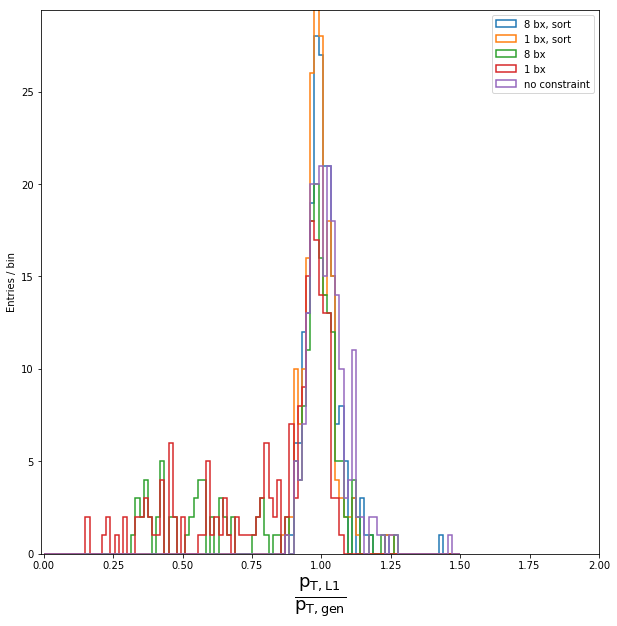

In [12]:
# mip_pt > 1 histograms

fig = plt.figure(figsize=(10, 10), facecolor='white')

ax = plt.subplot()
n_bins = 100
ax.hist(ratios['threshold_8bx_esort'][2.5], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_1bx_esort'][2.5], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_8bx_nosort'][2.5], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_1bx_nosort'][2.5], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
h, b, _ = ax.hist(ratios['baseline'][2.5], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')

ax.set_xlim(-0.01, 2.)
ax.set_ylim(0, 1.4*np.max(h))
#ax.set_xlabel(r'$\frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_xlabel(r'$\sf \frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_ylabel('Entries / bin')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
#labels = ['8 bx, sort', '8 bx', 'no constraint']
ax.legend(labels)

plt.savefig('plots/threshold_algo_resolution_e35.pdf')
plt.show()

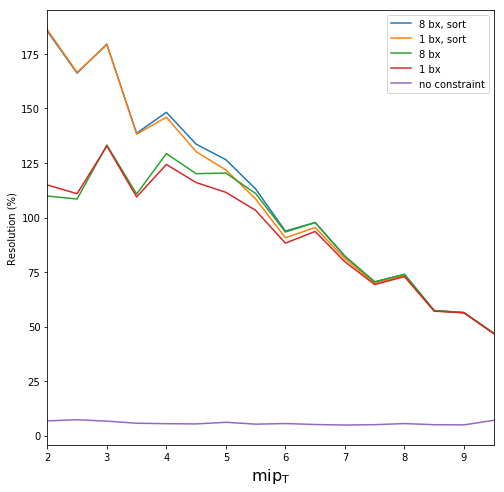

In [33]:
# mip_pt resolution scans
cuts = sorted(list(set(threshold_list)))
resolutions = {a:[100*algo_data[c].std() for c in cuts] for a, algo_data in ratios.items()}

fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='white')
ax.plot(cuts, resolutions['threshold_8bx_esort'])
ax.plot(cuts, resolutions['threshold_1bx_esort'])
ax.plot(cuts, resolutions['threshold_8bx_nosort'])
ax.plot(cuts, resolutions['threshold_1bx_nosort'])
ax.plot(cuts, resolutions['baseline'])

ax.set_xlim(2, 9.5)
ax.set_xlabel(r'$\sf mip_{T}$', fontsize=16)
ax.set_ylabel('Resolution (%)')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
ax.legend(labels)

plt.savefig('plots/resolution_mip_scan.pdf')
plt.savefig('plots/resolution_mip_scan.png')
plt.show()

In [ ]:
#
plt.scatter(particle_list[:,1], )